# Pet Segmentation using CLIP Features

This notebook trains a segmentation model using CLIP features on our augmented pet dataset with proper train/val/test splits.

## 1. Setup and Import Libraries

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import time
import clip

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Import modules from data_preprocessing.py
from src.data_preprocessing import PetDataset, JointTransform

# Set random seed for reproducibility
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
Total GPU memory: 17.18 GB
Available GPU memory: 15.96 GB


## 2. Custom Transform for CLIP

In [2]:
class CLIPJointTransform(JointTransform):
    def __init__(self, img_size=256, crop_size=224, p_flip=0.5, p_rotate=0.3, p_elastic=0.3):
        super().__init__(img_size=img_size, crop_size=crop_size, p_flip=p_flip, p_rotate=p_rotate, p_elastic=p_elastic)
        
        # CLIP normalization values
        self.mean = [0.48145466, 0.4578275, 0.40821073]
        self.std = [0.26862954, 0.26130258, 0.27577711]
    
    def __call__(self, image, mask):
        # Apply all transformations from parent class
        image_tensor, mask_tensor = super().__call__(image, mask)
        
        # Apply CLIP-specific normalization
        image_tensor = TF.normalize(image_tensor, mean=self.mean, std=self.std)
        
        return image_tensor, mask_tensor

## 3. Create Data Loaders

In [3]:
# Set paths and create datasets
data_root = '../Dataset_augmented/'

# Create transforms with CLIP normalization and appropriate augmentations
# For training: use all augmentations
train_transform = CLIPJointTransform(img_size=256, crop_size=256, p_flip=0.5, p_rotate=0.4, p_elastic=0.3)
# For validation and testing: no augmentation
val_transform = CLIPJointTransform(img_size=256, crop_size=256, p_flip=0, p_rotate=0, p_elastic=0)

# Create datasets using existing PetDataset class
train_dataset = PetDataset(data_root, 'train', transform=train_transform)
val_dataset = PetDataset(data_root, 'val', transform=val_transform)
test_dataset = PetDataset(data_root, 'test', transform=val_transform)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print(f"Checking dataset contents...")
train_dir = os.path.join(data_root, 'train', 'color')
print(f"Train image count: {len(os.listdir(train_dir))}")
print(f"Checking first few images...")
for i, f in enumerate(os.listdir(train_dir)[:5]):
    path = os.path.join(train_dir, f)
    size = os.path.getsize(path) / (1024*1024)  # Size in MB
    print(f"  {f}: {size:.2f} MB")

# Create dataloaders with specified batch size
batch_size = 16
num_workers = 0  # Use more workers for GPU training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Training set size: 11776
Validation set size: 736
Test set size: 3710
Checking dataset contents...
Train image count: 11776
Checking first few images...
  Maine_Coon_133.jpg: 0.19 MB
  Maine_Coon_133_aug0.jpg: 0.01 MB
  Maine_Coon_133_aug1.jpg: 0.01 MB
  Maine_Coon_133_aug2.jpg: 0.01 MB
  Siamese_200.jpg: 0.08 MB


## 4. CLIP Model Setup with Text Prompts

In [11]:
# Load CLIP model
clip_model, _ = clip.load("ViT-B/32", device=device)

# Freeze CLIP parameters (we'll only train the decoder)
for param in clip_model.parameters():
    param.requires_grad = False

# Define text prompts for classes
text_prompts = [
    "this is the background",
    "this is a cat", 
    "this is a dog"
]

# Pre-compute text embeddings
with torch.no_grad():
    text_tokens = clip.tokenize(text_prompts).to(device)
    text_features = clip_model.encode_text(text_tokens)
    # Normalize text features
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

print("CLIP model loaded and text features computed:")
print(f"Total CLIP parameters: {sum(p.numel() for p in clip_model.parameters()):,}")
print(f"Text features shape: {text_features.shape}")

CLIP model loaded and text features computed:
Total CLIP parameters: 151,277,313
Text features shape: torch.Size([3, 512])


## 5. CLIP-based Segmentation Model

In [28]:
class CLIPSegmentationModel(nn.Module):
    def __init__(self, clip_model, text_features, num_classes=3):
        super(CLIPSegmentationModel, self).__init__()
        self.clip_model = clip_model
        # Ensure text features are float32
        self.text_features = text_features.float()
        self.num_classes = num_classes
        
        # CLIP feature dimension
        clip_dim = 512  # ViT-B/32 output dimension
        
        # Input dimensions: CLIP features (512) + text similarities (3)
        input_dim = clip_dim + num_classes
        
        # Feature map size calculation for 224×224 input using ViT-B/32
        self.feature_size = 7  # Adjusted for 224×224 output
        
        # Resize for CLIP input (which expects 224x224)
        self.resize = transforms.Resize((224, 224))
        
        # Initial upsampling to create feature map
        self.initial_upscale = nn.Sequential(
            nn.Linear(input_dim, 512 * self.feature_size * self.feature_size),
            nn.ReLU(inplace=True)
        )
        
        # Decoder network adjusted for 224×224 output
        self.decoder = nn.Sequential(
            # Input: (512, 7, 7)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # (256, 14, 14)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 28, 28)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, num_classes, kernel_size=4, stride=2, padding=1)  # (num_classes, 224, 224)
        )
        
    def forward(self, x):
        # No need to resize if input is already 224x224
        x_clip = self.resize(x)
        
        # Extract image features from CLIP
        with torch.no_grad():
            image_features = self.clip_model.encode_image(x_clip)
            # Convert to float32
            image_features = image_features.float()
            
            # Normalize image features for text comparison
            normalized_features = image_features / image_features.norm(dim=1, keepdim=True)
            
            # Compute similarity with text prompts
            similarity = normalized_features @ self.text_features.T
        
        # Concatenate CLIP features with text similarities
        combined_features = torch.cat([image_features, similarity], dim=1)
        
        # Process through the decoder
        features_map = self.initial_upscale(combined_features)
        features_map = features_map.view(-1, 512, self.feature_size, self.feature_size)
        segmentation = self.decoder(features_map)
        
        return segmentation

In [29]:
# Create the model
clip_seg_model = CLIPSegmentationModel(clip_model, text_features).to(device)

print("CLIP Segmentation model created:")
print(f"Trainable parameters: {sum(p.numel() for p in clip_seg_model.parameters() if p.requires_grad):,}")

# Test forward pass
print("Testing model forward pass...")
with torch.no_grad():
    dummy_input = torch.randn(2, 3, 256, 256).to(device)
    _ = clip_seg_model(dummy_input)
print("Model verified, starting training...")

CLIP Segmentation model created:
Trainable parameters: 15,733,667
Testing model forward pass...
Model verified, starting training...


## 6. Training and Evaluation Functions

In [30]:
def train_clip_segmentation(model, train_loader, val_loader, num_epochs=20, cat_weight=2.1, device=device):
    """
    Train the CLIP-based segmentation model.
    
    Args:
        model: CLIP segmentation model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        cat_weight: Weight for the cat class
        device: Device to train on
        
    Returns:
        Trained model
    """
    
    # Add these lines at the beginning for mixed precision training
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
    accumulation_steps = 2  # Gradient accumulation steps
    
    print("Function started: train_clip_segmentation")
    start_time = time.time()
    
    # Define class weights to address class imbalance [background, cat, dog]
    print("Setting up class weights...")
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)
    print(f"Class weights created: {time.time() - start_time:.2f}s")

    # Define loss function with class weights and ignore_index for white pixels
    print("Setting up criterion...")
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    print(f"Criterion created: {time.time() - start_time:.2f}s")
    
    # Define optimizer with specified learning rate
    print("Setting up optimizer...")
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)  # Only train trainable params
    print(f"Optimizer created: {time.time() - start_time:.2f}s")
    
    # Test data loading
    print("Testing data loading...")
    try:
        test_imgs, test_masks = next(iter(train_loader))
        print(f"Sample batch loaded - images: {test_imgs.shape}, masks: {test_masks.shape}")
        print(f"Data loading test: {time.time() - start_time:.2f}s")
        
        # Test batch to GPU transfer
        print("Testing batch GPU transfer...")
        test_imgs = test_imgs.to(device)
        test_masks = test_masks.to(device)
        print(f"GPU transfer test: {time.time() - start_time:.2f}s")
        
        # Test forward pass
        print("Testing forward pass...")
        with torch.no_grad():
            test_output = model(test_imgs)
        print(f"Forward pass test: {time.time() - start_time:.2f}s")
    except Exception as e:
        print(f"Error in data loading test: {e}")
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    train_iou = []
    val_iou = []
    train_dice = []
    val_dice = []
    prev_lr = optimizer.param_groups[0]['lr']
    
    # Create figures for live plotting
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # GPU memory tracking
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            mem_allocated_start = torch.cuda.memory_allocated() / 1e9
        
        # Training phase
        model.train()
        running_loss = 0.0
        intersection = torch.zeros(3, device=device)
        union = torch.zeros(3, device=device)
        dice_intersection = torch.zeros(3, device=device)
        dice_sum = torch.zeros(3, device=device)
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=True)
        
        # Reset gradients at the start of each epoch
        optimizer.zero_grad()
        batch_count = 0
        
        for images, masks in train_pbar:
            batch_count += 1
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass with mixed precision
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            # Scale loss by accumulation steps and backward pass
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()
            
            # Update weights after accumulation_steps
            if batch_count % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            # Track loss (use the original loss value for tracking)
            running_loss += (loss.item() * accumulation_steps) * images.size(0)
            
            # Calculate metrics (use non-scaled outputs)
            with torch.no_grad():
                _, predicted = torch.max(outputs, 1)
                mask = (masks != 255)
                
                # Calculate IoU and Dice metrics
                for cls in range(3):
                    pred_cls = (predicted == cls) & mask
                    true_cls = (masks == cls) & mask
                    
                    intersection[cls] += (pred_cls & true_cls).sum().float()
                    union[cls] += (pred_cls | true_cls).sum().float()
                    
                    dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                    dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
            
            # Update progress bar
            train_pbar.set_postfix(loss=loss.item() * accumulation_steps)
        
        # Make sure to update for any remaining batches (if dataset size % accumulation_steps != 0)
        if batch_count % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Calculate average training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Calculate IoU
        class_ious = []
        for cls in range(3):
            iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
            class_ious.append(iou.item())
        mean_iou = sum(class_ious) / len(class_ious)
        train_iou.append(mean_iou)
        
        # Calculate Dice coefficient
        class_dice = []
        for cls in range(3):
            dice = (2 * dice_intersection[cls]) / dice_sum[cls] if dice_sum[cls] > 0 else 0
            class_dice.append(dice.item())
        mean_dice = sum(class_dice) / len(class_dice)
        train_dice.append(mean_dice)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_intersection = torch.zeros(3, device=device)
        val_union = torch.zeros(3, device=device)
        val_dice_intersection = torch.zeros(3, device=device)
        val_dice_sum = torch.zeros(3, device=device)
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False)
        
        with torch.no_grad():
            for images, masks in val_pbar:
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
                
                # Calculate metrics
                _, predicted = torch.max(outputs, 1)
                mask = (masks != 255)
                
                # Calculate IoU
                for cls in range(3):  # 3 classes: background, cat, dog
                    pred_cls = (predicted == cls) & mask
                    true_cls = (masks == cls) & mask
                    
                    # Intersection and union
                    val_intersection[cls] += (pred_cls & true_cls).sum().float()
                    val_union[cls] += (pred_cls | true_cls).sum().float()
                    
                    # Dice coefficient
                    val_dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                    val_dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
                
                # Update progress bar
                val_pbar.set_postfix(loss=loss.item())
        
        # Calculate average validation metrics
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Calculate IoU
        val_class_ious = []
        for cls in range(3):
            iou = val_intersection[cls] / val_union[cls] if val_union[cls] > 0 else 0
            val_class_ious.append(iou.item())
        val_mean_iou = sum(val_class_ious) / len(val_class_ious)
        val_iou.append(val_mean_iou)
        
        # Calculate Dice coefficient
        val_class_dice = []
        for cls in range(3):
            dice = (2 * val_dice_intersection[cls]) / val_dice_sum[cls] if val_dice_sum[cls] > 0 else 0
            val_class_dice.append(dice.item())
        val_mean_dice = sum(val_class_dice) / len(val_class_dice)
        val_dice.append(val_mean_dice)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Check for learning rate changes
        current_lr = optimizer.param_groups[0]['lr']
        lr_changed = current_lr != prev_lr
        
        # GPU memory usage
        gpu_info = ""
        if torch.cuda.is_available():
            mem_allocated_peak = torch.cuda.max_memory_allocated() / 1e9
            mem_allocated_end = torch.cuda.memory_allocated() / 1e9
            gpu_info = f", Peak GPU Memory: {mem_allocated_peak:.2f} GB"
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s{gpu_info}")
        print(f"  Train: Loss={train_loss:.4f}, IoU={mean_iou:.4f}, Dice={mean_dice:.4f}")
        print(f"  Val: Loss={val_loss:.4f}, IoU={val_mean_iou:.4f}, Dice={val_mean_dice:.4f}")
        
        if lr_changed:
            print(f"  Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"  New best model saved with validation loss: {val_loss:.4f}")
            
            # Save checkpoint
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_iou': mean_iou,
                'val_iou': val_mean_iou,
                'train_dice': mean_dice,
                'val_dice': val_mean_dice
            }, 'clip_pet_segmentation_best.pt')
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_iou': mean_iou,
                'val_iou': val_mean_iou,
                'train_dice': mean_dice,
                'val_dice': val_mean_dice
            }, f'clip_pet_segmentation_epoch_{epoch+1}.pt')
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Save final model
    torch.save(model.state_dict(), 'clip_pet_segmentation_final.pth')
    
    # Create final plots
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_iou, 'b--', label='Train IoU')
    plt.plot(val_iou, 'r--', label='Val IoU')
    plt.plot(train_dice, 'b-', label='Train Dice')
    plt.plot(val_dice, 'r-', label='Val Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('IoU and Dice Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('clip_training_curves.png')
    plt.show()
    
    return model, {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_iou,
        'val_iou': val_iou,
        'train_dice': train_dice,
        'val_dice': val_dice
    }

In [31]:
def evaluate_clip_segmentation(model, dataloader, device):
    """
    Evaluate the CLIP-based segmentation model.
    
    Args:
        model: CLIP segmentation model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU and Dice metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    dice_intersection = torch.zeros(num_classes, device=device)
    dice_sum = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU and Dice for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().float()
                union[cls] += (pred_cls | true_cls).sum().float()
                
                # Dice coefficient
                dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    class_dice = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou.item())
        
        dice = (2 * dice_intersection[cls]) / dice_sum[cls] if dice_sum[cls] > 0 else 0
        class_dice.append(dice.item())
        
        print(f"Class '{class_names[cls]}': IoU={iou:.4f}, Dice={dice:.4f}")
    
    # Calculate mean IoU and Dice
    mean_iou = sum(class_ious) / len(class_ious)
    mean_dice = sum(class_dice) / len(class_dice)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou,
        "class_dice": {class_names[i]: class_dice[i] for i in range(num_classes)},
        "mean_dice": mean_dice
    }

In [32]:
def visualize_clip_results(model, dataloader, device, num_samples=3):
    """
    Visualize the CLIP-based segmentation model predictions.
    
    Args:
        model: CLIP segmentation model
        dataloader: DataLoader for visualization data
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(images[:num_samples].to(device))
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            # Denormalize using CLIP normalization values
            mean = np.array([0.48145466, 0.4578275, 0.40821073])
            std = np.array([0.26862954, 0.26130258, 0.27577711])
            img = img * std + mean
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 1].imshow(mask_rgb)
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

## 7. Train the CLIP Segmentation Model

Training CLIP Segmentation model...
Function started: train_clip_segmentation
Setting up class weights...
Class weights created: 0.00s
Setting up criterion...
Criterion created: 0.00s
Setting up optimizer...
Optimizer created: 0.00s
Testing data loading...


C:\Users\dcb_r\AppData\Local\Temp\ipykernel_800\3075044598.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Sample batch loaded - images: torch.Size([16, 3, 224, 224]), masks: torch.Size([16, 224, 224])
Data loading test: 0.25s
Testing batch GPU transfer...
GPU transfer test: 0.25s
Testing forward pass...
Forward pass test: 0.26s


Epoch 1/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

C:\Users\dcb_r\AppData\Local\Temp\ipykernel_800\3075044598.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1/20] - 250.6s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.5765, IoU=0.5905, Dice=0.7403
  Val: Loss=0.3970, IoU=0.6714, Dice=0.8015
  New best model saved with validation loss: 0.3970


Epoch 2/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 2/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [2/20] - 250.9s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.4284, IoU=0.6566, Dice=0.7915
  Val: Loss=0.3735, IoU=0.6810, Dice=0.8083
  New best model saved with validation loss: 0.3735


Epoch 3/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 3/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [3/20] - 250.0s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.4068, IoU=0.6643, Dice=0.7972
  Val: Loss=0.3577, IoU=0.6873, Dice=0.8124
  New best model saved with validation loss: 0.3577


Epoch 4/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 4/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [4/20] - 249.5s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3922, IoU=0.6705, Dice=0.8017
  Val: Loss=0.3515, IoU=0.6874, Dice=0.8130
  New best model saved with validation loss: 0.3515


Epoch 5/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 5/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [5/20] - 249.2s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3844, IoU=0.6744, Dice=0.8045
  Val: Loss=0.3582, IoU=0.6825, Dice=0.8093


Epoch 6/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 6/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [6/20] - 247.8s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3795, IoU=0.6778, Dice=0.8070
  Val: Loss=0.3441, IoU=0.6946, Dice=0.8178
  New best model saved with validation loss: 0.3441


Epoch 7/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 7/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [7/20] - 249.1s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3757, IoU=0.6801, Dice=0.8086
  Val: Loss=0.3441, IoU=0.6951, Dice=0.8184
  New best model saved with validation loss: 0.3441


Epoch 8/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 8/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [8/20] - 251.7s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3698, IoU=0.6819, Dice=0.8100
  Val: Loss=0.3498, IoU=0.6904, Dice=0.8150


Epoch 9/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 9/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [9/20] - 248.3s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3662, IoU=0.6852, Dice=0.8123
  Val: Loss=0.3431, IoU=0.6844, Dice=0.8109
  New best model saved with validation loss: 0.3431


Epoch 10/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 10/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [10/20] - 250.7s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3638, IoU=0.6869, Dice=0.8135
  Val: Loss=0.3380, IoU=0.6936, Dice=0.8171
  New best model saved with validation loss: 0.3380


Epoch 11/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 11/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [11/20] - 251.0s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3586, IoU=0.6898, Dice=0.8155
  Val: Loss=0.3515, IoU=0.6837, Dice=0.8106


Epoch 12/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 12/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [12/20] - 249.4s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3563, IoU=0.6916, Dice=0.8168
  Val: Loss=0.3457, IoU=0.6896, Dice=0.8142


Epoch 13/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 13/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [13/20] - 248.5s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3510, IoU=0.6949, Dice=0.8192
  Val: Loss=0.3441, IoU=0.6919, Dice=0.8159


Epoch 14/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 14/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [14/20] - 249.3s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3481, IoU=0.6965, Dice=0.8203
  Val: Loss=0.3397, IoU=0.6942, Dice=0.8177


Epoch 15/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 15/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [15/20] - 248.5s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3458, IoU=0.6986, Dice=0.8217
  Val: Loss=0.3421, IoU=0.6911, Dice=0.8151


Epoch 16/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 16/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [16/20] - 252.1s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3412, IoU=0.7010, Dice=0.8234
  Val: Loss=0.3460, IoU=0.6875, Dice=0.8130
  Learning rate changed from 0.000100 to 0.000050


Epoch 17/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 17/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [17/20] - 250.2s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3341, IoU=0.7054, Dice=0.8265
  Val: Loss=0.3394, IoU=0.6974, Dice=0.8201


Epoch 18/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 18/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [18/20] - 248.0s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3304, IoU=0.7073, Dice=0.8278
  Val: Loss=0.3391, IoU=0.7001, Dice=0.8218


Epoch 19/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 19/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [19/20] - 248.0s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3274, IoU=0.7104, Dice=0.8299
  Val: Loss=0.3388, IoU=0.6921, Dice=0.8161


Epoch 20/20 (Train):   0%|          | 0/736 [00:00<?, ?it/s]

Epoch 20/20 (Val):   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [20/20] - 250.4s, Peak GPU Memory: 1.00 GB
  Train: Loss=0.3259, IoU=0.7121, Dice=0.8311
  Val: Loss=0.3422, IoU=0.6976, Dice=0.8200


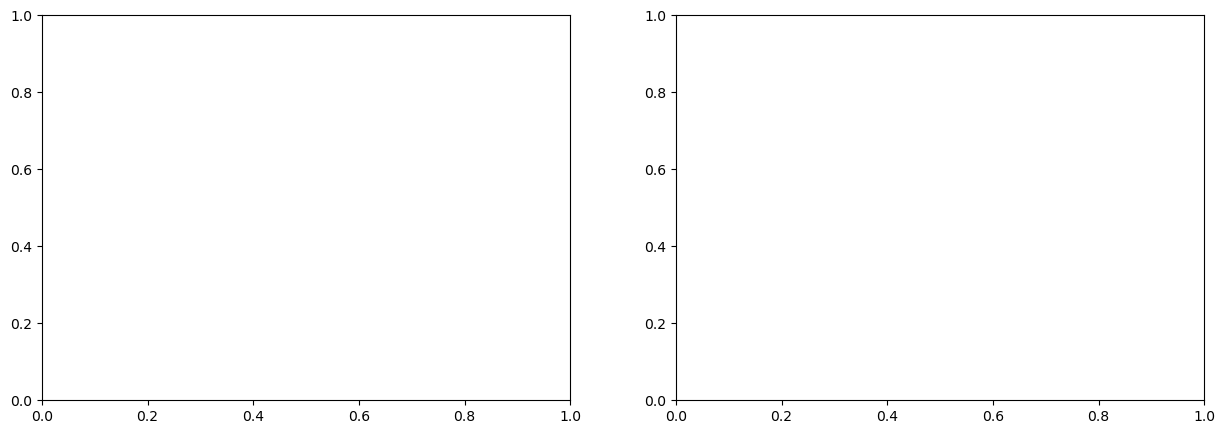

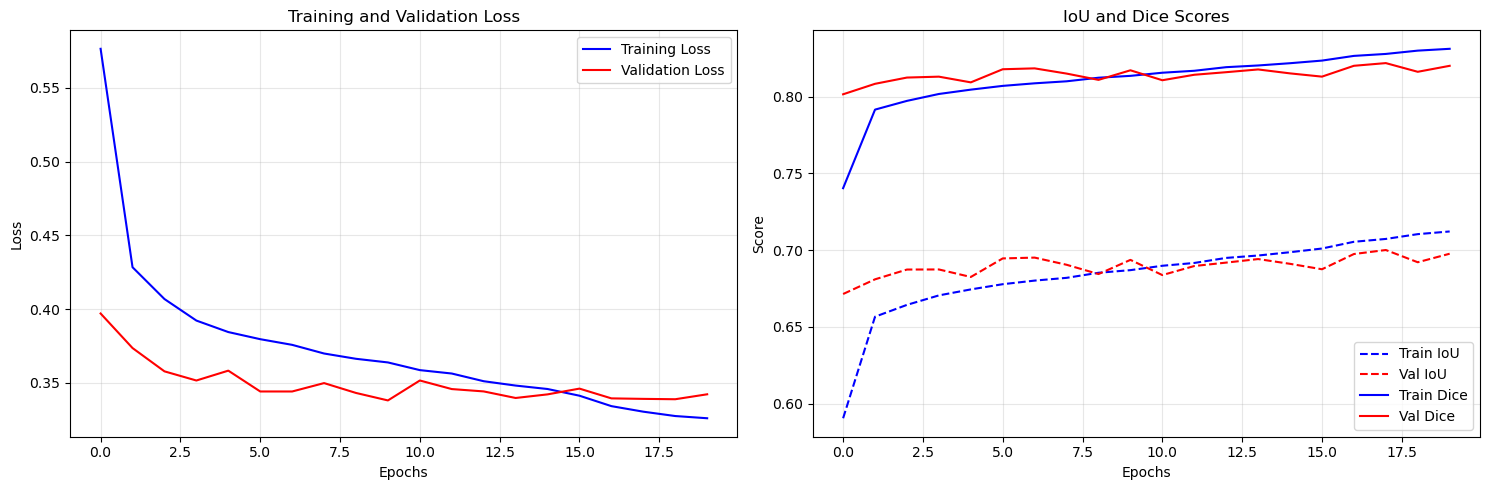

Training complete!


In [33]:
print("Training CLIP Segmentation model...")
num_epochs = 20  # As specified in requirements
cat_weight = 2.1  # Same weight as U-Net for consistent comparison
clip_seg_model, history = train_clip_segmentation(clip_seg_model, train_loader, val_loader, num_epochs=num_epochs, cat_weight=cat_weight, device=device)
print("Training complete!")

## 8. Evaluate Model

In [34]:
# Evaluate model on validation set
print("\nEvaluating CLIP Segmentation on validation set:")
val_results = evaluate_clip_segmentation(clip_seg_model, val_loader, device)


Evaluating CLIP Segmentation on validation set:


Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Class 'background': IoU=0.7914, Dice=0.8836
Class 'cat': IoU=0.6712, Dice=0.8032
Class 'dog': IoU=0.6339, Dice=0.7760
Pixel Accuracy: 0.8492
Mean IoU: 0.6988
Mean Dice: 0.8209



Visualizing CLIP Segmentation results on validation set:


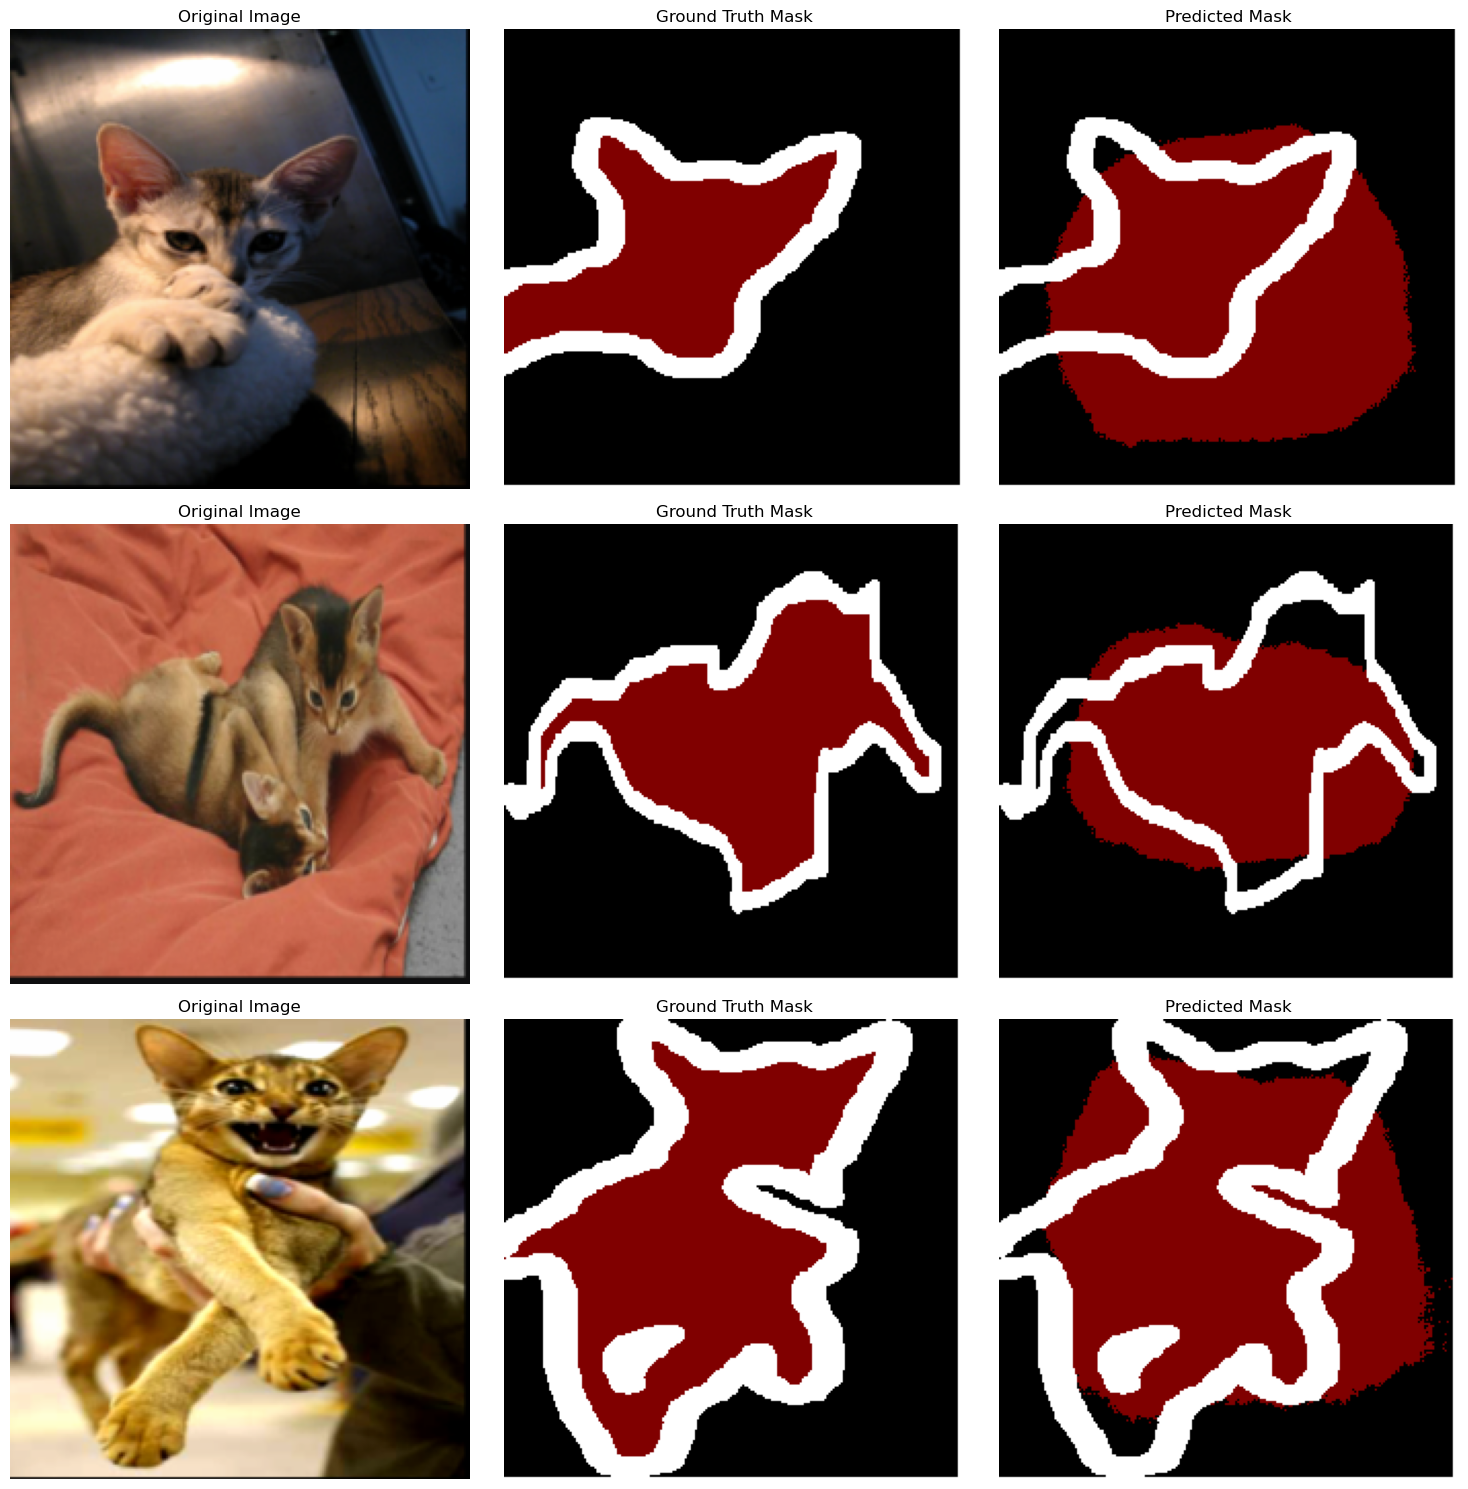

In [35]:
# Visualize results on validation set
print("\nVisualizing CLIP Segmentation results on validation set:")
visualize_clip_results(clip_seg_model, val_loader, device, num_samples=3)

In [36]:
# Evaluate model on test set
print("\nEvaluating CLIP Segmentation on test set:")
test_results = evaluate_clip_segmentation(clip_seg_model, test_loader, device)


Evaluating CLIP Segmentation on test set:


Evaluating:   0%|          | 0/232 [00:00<?, ?it/s]

Class 'background': IoU=0.8003, Dice=0.8891
Class 'cat': IoU=0.6646, Dice=0.7985
Class 'dog': IoU=0.6527, Dice=0.7899
Pixel Accuracy: 0.8555
Mean IoU: 0.7059
Mean Dice: 0.8258



Visualizing CLIP Segmentation results on test set:


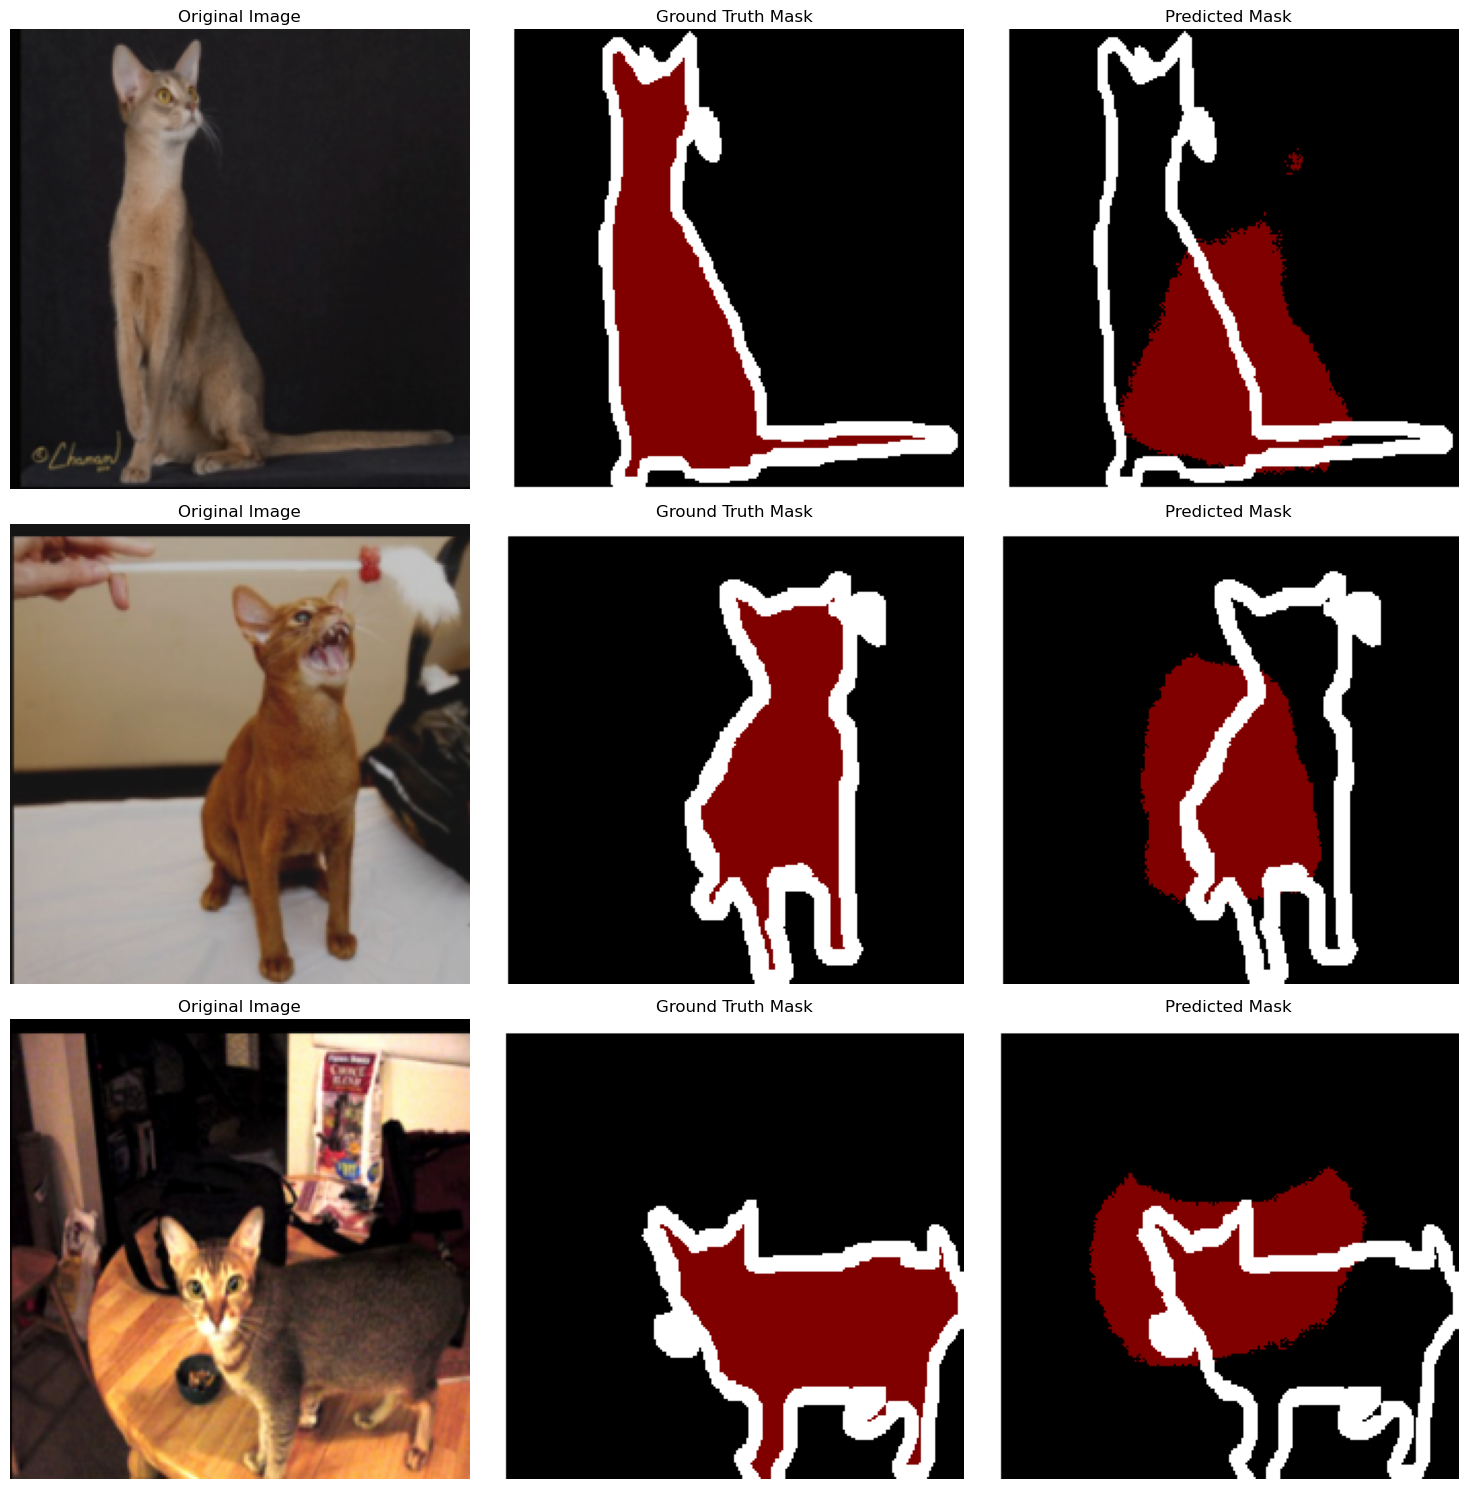

In [37]:
# Visualize results on test set
print("\nVisualizing CLIP Segmentation results on test set:")
visualize_clip_results(clip_seg_model, test_loader, device, num_samples=3)

## 9. Save Final Results and Model

In [38]:
# Display final results
print("\nFinal Results:")
print("Validation Set:")
print(f"  Pixel Accuracy: {val_results['pixel_accuracy']:.4f}")
print(f"  Mean IoU: {val_results['mean_iou']:.4f}")
print(f"  Mean Dice: {val_results['mean_dice']:.4f}")
print("Test Set:")
print(f"  Pixel Accuracy: {test_results['pixel_accuracy']:.4f}")
print(f"  Mean IoU: {test_results['mean_iou']:.4f}")
print(f"  Mean Dice: {test_results['mean_dice']:.4f}")

# Class-wise results
print("\nClass-wise Results:")
class_names = ["background", "cat", "dog"]
print("IoU:")
for cls in class_names:
    print(f"  {cls}: {test_results['class_ious'][cls]:.4f}")
print("Dice:")
for cls in class_names:
    print(f"  {cls}: {test_results['class_dice'][cls]:.4f}")

# Save the trained model one more time
torch.save(clip_seg_model.state_dict(), 'clip_pet_segmentation_final.pth')
print("Model saved to clip_pet_segmentation_final.pth")

# Compare validation and test results to verify train/val split
print("\nComparison between Validation and Test results:")
print(f"  Validation Mean IoU: {val_results['mean_iou']:.4f}")
print(f"  Test Mean IoU: {test_results['mean_iou']:.4f}")
print(f"  Difference: {abs(val_results['mean_iou'] - test_results['mean_iou']):.4f}")


Final Results:
Validation Set:
  Pixel Accuracy: 0.8492
  Mean IoU: 0.6988
  Mean Dice: 0.8209
Test Set:
  Pixel Accuracy: 0.8555
  Mean IoU: 0.7059
  Mean Dice: 0.8258

Class-wise Results:
IoU:
  background: 0.8003
  cat: 0.6646
  dog: 0.6527
Dice:
  background: 0.8891
  cat: 0.7985
  dog: 0.7899
Model saved to clip_pet_segmentation_final.pth

Comparison between Validation and Test results:
  Validation Mean IoU: 0.6988
  Test Mean IoU: 0.7059
  Difference: 0.0070
